In [1]:
import cv2
import numpy as np
import json
from PIL import Image

In [2]:
with open("../data/train.json", "r") as jfile:
    train_filenames = json.load(jfile)

In [3]:
train_filenames[0]

'4fc2470c0f7b_06'

In [6]:
train_uid = "4fc2470c0f7b"

In [20]:
%timeit cv2.blur(imgs[0, ...], (15, 15))

36.7 ms ± 2.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [21]:
1280/8

160.0

In [52]:
import os

In [53]:
def get_car_ids(filenames):
    car_ids = set()
    for fn in filenames:
        basename = os.path.basename(fn)
        car_id = basename.split("_")[0]
        car_ids.add(car_id)
    return car_ids

In [ ]:
def compute_car_median(car_id, src_dir, dst_dir, dst_size=(240, 160)):
    n_rotations = 16
    blur = 3
    # Load all images, resize and blur
    imgs = np.zeros((n_rotations,) + dst_size + (3, ), dtype=np.uint8)
    for rot in range(1, n_rotations + 1):
        basename = car_id + "_{:02d}".format(rot)
        src_filename = os.path.join(src_dir, basename + ".jpg")
        img = cv2.imread(src_filename)
        img = cv2.resize(img, dst_size, interpolation=cv2.INTER_LINEAR)
        img = cv2.medianBlur(img, blur)
        imgs[rot-1, ...] = img
    # Get the median and save it
    median = np.round(np.median(imgs, axis=0)).astype(np.uint8)
    dst_filename = os.path.join(dst_dir, basename + ".png")
    cv2.imwrite(dst_filename, median)

In [32]:
imgs = np.zeros((16, 160, 240, 3), dtype=np.uint8)
for i in range(1, 17):
    fn = train_uid + "_{:02d}".format(i) + ".jpg"
    img = cv2.imread("../data/train/" + fn)
    img = cv2.resize(img, (240, 160), interpolation=cv2.INTER_LINEAR)
    img = cv2.medianBlur(img, 3)
    if img is not None:
        imgs[i-1, ...] = img


In [55]:
def get_foreground_bbox(img, median, threshold=30):
    hr, wr, _ = median.shape
    h, w, _ = img.shape
    
    img_resized = cv2.resize(img, (wr, hr), interpolation=cv2.INTER_LINEAR)
    img_resized = cv2.medianBlur(img_resized, 3)
    
    diff = np.abs(img_resized.astype(np.int32) - median.astype(np.int32))
    mask = diff > threshold
    y, x = np.nonzero(mask)
    xmin, xmax = np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    
    s = w/wr
    xmin = np.round(xmin * s)
    xmax = np.round(xmax * s)
    ymin = np.round(ymin * s)
    ymax = np.round(ymax * s)
    
    return (xmin, xmax), (ymin, ymax)

In [33]:
imgs.shape

(16, 160, 240, 3)

In [34]:
median = np.median(imgs, axis=0)

In [51]:
median

array([[[ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        ..., 
        [ 231. ,  230. ,  234. ],
        [ 231. ,  230. ,  234. ],
        [ 231. ,  230. ,  234. ]],

       [[ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        ..., 
        [ 231. ,  230. ,  234. ],
        [ 231. ,  230. ,  234. ],
        [ 231. ,  230. ,  234. ]],

       [[ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        [ 248. ,  243. ,  244. ],
        ..., 
        [ 231. ,  230. ,  234. ],
        [ 230. ,  229. ,  233. ],
        [ 230. ,  229. ,  233. ]],

       ..., 
       [[ 216. ,  208. ,  209. ],
        [ 218. ,  211. ,  212. ],
        [ 218. ,  213. ,  214. ],
        ..., 
        [ 219. ,  218. ,  222. ],
        [ 219. ,  218. ,  222. ],
        [ 219. ,  218. ,  221. ]],

       [[ 216. ,  212. ,  212. ],
        [ 218. ,  212. ,  212. ],
        [ 218. ,  213. ,  214. ],
     

In [35]:
median.dtype

dtype('float64')

In [36]:
diff = np.abs((imgs.astype(np.float32) - median))

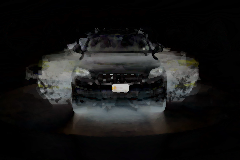

In [37]:
Image.fromarray(diff[0, ...].astype(np.uint8))

In [38]:
diff_rgb = np.sum(diff, axis=-1)

In [39]:
mask_predict = diff_rgb[13, ...] > 30

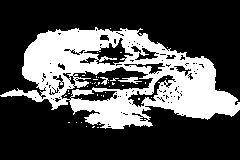

In [40]:
Image.fromarray(((diff_rgb[13, ...] > 30) * 255).astype(np.uint8))

In [43]:
x, y = np.nonzero(mask_predict)

In [47]:
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)

In [50]:
xmin, xmax, ymin, ymax

(27, 128, 0, 239)

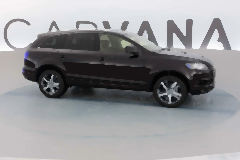

In [41]:
Image.fromarray(imgs[13, ...])